In [22]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime

In [23]:
api_key = '3mBQlhZHYSvrS37Nt47CNuDAH'
api_secret = 'ZmGYg594O5AVABdYFRM8QkIaubVDauRfpncALnm9ilaBZL47h8'
access_token = '1065785581601345536-LLAnqdBWVk5NQ3P2TOfxv87RDn0spJ'
access_token_secret = 'MMwkQHuZNH5WoYOsAy300iPdw4f8YMuPCKRhQ7Uw0Jngg'

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)
col = pymongo.MongoClient()["twitter"]["kolkata1"]
col.count()

C:\Users\Asus\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  # This is added back by InteractiveShellApp.init_path()


5000

In [3]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=5000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        # Increment counter
        self.counter += 1
        
        # Store tweet to MongoDB
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
            #print("%s/%s" % (self.counter, self.max_tweets))
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=5000)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
keywords = ["Kolkata Knight Riders",
            "KolkataKnightRiders",
            "KKR"
           ]

# Visualize a progress bar to track progress
progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)

# Start a filter with an error counter of 20
for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

IntProgress(value=0)

HTML(value='<span class="label label-primary">Tweets/Sec: 0.0</span>')

Finished
Total Mining Time: 0:36:02.969084
Tweets/Sec: 2.3
Tweets collected: 5000
Total tweets in collection: 5000


C:\Users\Asus\miniconda3\lib\site-packages\ipykernel_launcher.py:57: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere


In [24]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset = pd.DataFrame(dataset)
dataset.head()

,created_at,text,user,source,lang
0,Sun Nov 01 13:41:38 +0000 2020,@KKRiders at the last place. Such a great sigh...,@Sharma_Rjdp,"<a href=""http://twitter.com/download/android"" ...",en
1,Sun Nov 01 13:41:38 +0000 2020,RT @ChennaiIPL: One for the Super Fans...\n\n....,@Kashyap_ocean,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
2,Sun Nov 01 13:41:38 +0000 2020,RT @ChennaiIPL: One for the Super Fans...\n\n....,@Priyan7Muthu,"<a href=""http://twitter.com/download/android"" ...",en
3,Sun Nov 01 13:41:38 +0000 2020,@RahulRyon Ab khon jitega KKR vs RR,@Salman53312001,"<a href=""http://twitter.com/download/android"" ...",in
4,Sun Nov 01 13:41:39 +0000 2020,RT @ChennaiIPL: One for the Super Fans...\n\n....,@veri_thano,"<a href=""http://twitter.com/download/android"" ...",en


In [25]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:20]

,word,count
0,kkr,4273
1,and,3624
2,rt,2795
3,the,2775
4,rr,2337
5,rcb,2193
6,dc,2010
7,for,1989
8,srh,1947
9,chennaiipl,1741


C:\Users\Asus\miniconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


IFTTT                     3
                          5
Twitter for iPad          6
CricketKhabarLive         9
CricketNDTVLive          10
WordPress.com            67
TweetDeck                75
Twitter for iPhone      369
Twitter Web App         570
Twitter for Android    3852
Name: source, dtype: int64

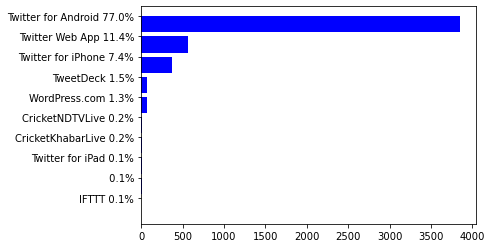

In [7]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="blue", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts

ne        9
ht       16
nl       18
tl       53
et       71
ta       88
in      122
hi      146
und     207
en     4217
Name: lang, dtype: int64

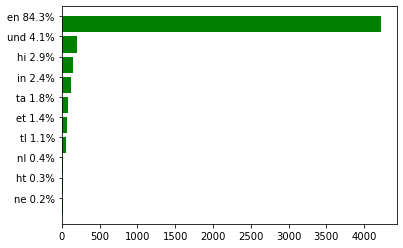

In [8]:
lang_counts = dataset.lang.value_counts().sort_values()[-10:]
bottom = [index for index, item in enumerate(lang_counts.index)]
plt.barh(bottom, width=lang_counts, color="green", linewidth=0)
y_labels = ["%s %.1f%%" % (item, 100.0*lang_counts[item]/len(dataset)) for index,item in enumerate(lang_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
lang_counts

In [26]:
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [28]:
dataset1 = [{"id": item["id"],
            "text": item["text"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset1 = pd.DataFrame(dataset1)
is_dataset1=dataset1.lang=="en"
dataset1=dataset1[is_dataset1]
dataset1.head()

,id,text,lang
0,1322896583826944000,@KKRiders at the last place. Such a great sigh...,en
1,1322896585341087744,RT @ChennaiIPL: One for the Super Fans...\n\n....,en
2,1322896585764712448,RT @ChennaiIPL: One for the Super Fans...\n\n....,en
4,1322896586431606784,RT @ChennaiIPL: One for the Super Fans...\n\n....,en
5,1322896589724160000,RT @ChennaiIPL: One for the Super Fans...\n\n....,en


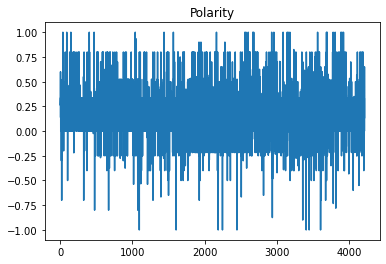

In [29]:
from  textblob import TextBlob
tweettext=dataset1['text']
wordlist=pd.DataFrame();

polarity=[]
subj=[]

for t in tweettext:
    tx= TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

poltweet= pd.DataFrame({'polarity':polarity,'subjectivity':subj})
poltweet.polarity.plot(title='Polarity')
plt.show()

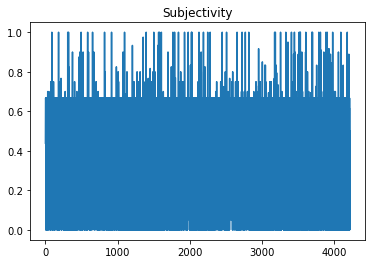

In [12]:
poltweet.subjectivity.plot(title='Subjectivity')
plt.show()

In [13]:
import statistics
statistics.mean(poltweet.polarity)

0.2014705996130513

In [14]:
import statistics
statistics.mean(poltweet.subjectivity)

0.41342369400200796

In [30]:
#Fuction to get clean text to get better analysis
def cleanText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    
    return text

dataset1['text'] = dataset1['text'].apply(cleanText)

dataset1

,id,text,lang
0,1322896583826944000,at the last place. Such a great sight. Hope t...,en
1,1322896585341087744,": One for the Super Fans...\n\n...and RCB, DC,...",en
2,1322896585764712448,": One for the Super Fans...\n\n...and RCB, DC,...",en
4,1322896586431606784,": One for the Super Fans...\n\n...and RCB, DC,...",en
5,1322896589724160000,": One for the Super Fans...\n\n...and RCB, DC,...",en
...,...,...,...
4994,1322905630970183680,: Had CSK avoided the choke against KKR/SRH!\n...,en
4995,1322905642663772161,": One for the Super Fans...\n\n...and RCB, DC,...",en
4997,1322905655255076864,Table Toppers 💪 .. Ami KKR we Rule .. KKR Hai...,en
4998,1322905655783481346,_massified: RR - need to chase the target befo...,en


In [31]:
#Fuction to get subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

dataset1['Subjectivity'] = dataset1['text'].apply(getSubjectivity)
dataset1['Polarity'] = dataset1['text'].apply(getPolarity)

dataset1.head()

,id,text,lang,Subjectivity,Polarity
0,1322896583826944000,at the last place. Such a great sight. Hope t...,en,0.438889,0.266667
1,1322896585341087744,": One for the Super Fans...\n\n...and RCB, DC,...",en,0.666667,0.333333
2,1322896585764712448,": One for the Super Fans...\n\n...and RCB, DC,...",en,0.666667,0.333333
4,1322896586431606784,": One for the Super Fans...\n\n...and RCB, DC,...",en,0.666667,0.333333
5,1322896589724160000,": One for the Super Fans...\n\n...and RCB, DC,...",en,0.666667,0.333333


In [32]:
#Function to compute positive negative neutral analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
dataset1['Analysis'] = dataset1['Polarity'].apply(getAnalysis)

dataset1.head()

,id,text,lang,Subjectivity,Polarity,Analysis
0,1322896583826944000,at the last place. Such a great sight. Hope t...,en,0.438889,0.266667,Positive
1,1322896585341087744,": One for the Super Fans...\n\n...and RCB, DC,...",en,0.666667,0.333333,Positive
2,1322896585764712448,": One for the Super Fans...\n\n...and RCB, DC,...",en,0.666667,0.333333,Positive
4,1322896586431606784,": One for the Super Fans...\n\n...and RCB, DC,...",en,0.666667,0.333333,Positive
5,1322896589724160000,": One for the Super Fans...\n\n...and RCB, DC,...",en,0.666667,0.333333,Positive


In [33]:
#percentage of positive
ptweets = dataset1[dataset1.Analysis == 'Positive']
ptweets = ptweets['text']

round( (ptweets.shape[0] / dataset1.shape[0]) *100,1)

64.0

In [19]:
#percentage of negative
ntweets = dataset1[dataset1.Analysis == 'Negative']
ntweets = ntweets['text']

round( (ntweets.shape[0] / dataset1.shape[0]) *100,1)

11.2

In [20]:
#percentage of neutral
neutweets = dataset1[dataset1.Analysis == 'Neutral']
neutweets = neutweets['text']

round( (neutweets.shape[0] / dataset1.shape[0]) *100,1)

24.9

In [34]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (10,10))
    wc = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [35]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
top_N = 100
#convert list of list into text
#a=''.join(str(r) for v in df_usa['title'] for r in v)

a = dataset1['text'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)
nltk.download('stopwords')
#remove all the stopwords from the text
nltk.download('punkt')
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


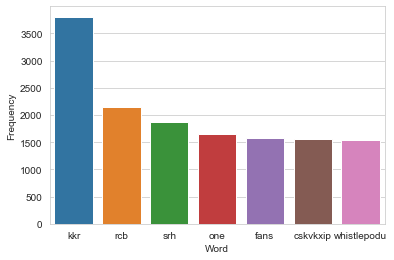

In [36]:
import seaborn as sns
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure()
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

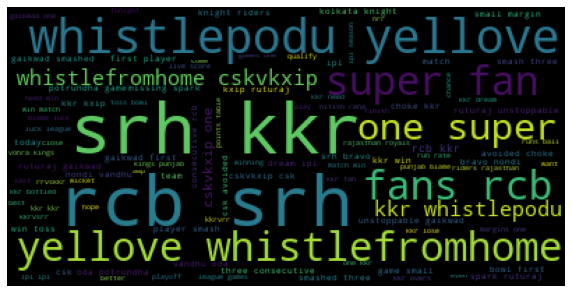

In [37]:
wc(cleaned_data_title,'black','Common Words' )

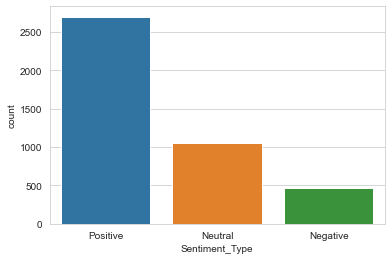

In [38]:
from textblob import TextBlob

bloblist_desc = list()

twit=dataset1['text'].astype(str)
for row in twit:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    twit_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
    
def f(twit_polarity_desc):
    if twit_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif twit_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

twit_polarity_desc['Sentiment_Type'] = twit_polarity_desc.apply(f, axis=1)

plt.figure()
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=twit_polarity_desc)

In [39]:
import collections, numpy as np
a=twit_polarity_desc.Sentiment_Type
neut=np.count_nonzero(a == 'Neutral')
pos=np.count_nonzero(a == 'Positive')
neg=np.count_nonzero(a == 'Negative')
popularity='{0:.2f}'.format((((neut*0.5)+(pos)+(neg*0))/(neut+pos+neg))*100)
popularity

'76.38'